Prueba RappiPay - Data Science

In [1]:
## clonando el repositorio
!git clone https://bitbucket.org/carlwhandlin/rpp-ds-challenge.git

Cloning into 'rpp-ds-challenge'...
Unpacking objects: 100% (7/7), done.


In [2]:
!pip install shap
!pip install scorecardpy
!pip install sweetviz

     |████████████████████████████████| 564 kB 4.6 MB/s 
     |████████████████████████████████| 55 kB 2.5 MB/s 
  Created wheel for scorecardpy: filename=scorecardpy-0.1.9.2-py3-none-any.whl size=57843 sha256=0a57177bcdf6421796f490c027ba3b2e6aa3081d7b749fbe2d324a43d66a3eb2
  Stored in directory: /root/.cache/pip/wheels/9d/50/52/715367c478fd2e2317070ccf6539b2c29fc8168144cfbfaeac
Successfully built scorecardpy
     |████████████████████████████████| 15.1 MB 440 kB/s 


In [3]:
import numpy as np
import itertools
import pandas as pd
import gc
import datetime
import sweetviz as sv
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
from scipy import stats
from seaborn import violinplot
import seaborn as sns
import shap
import scorecardpy as sc
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgbm
from matplotlib import pyplot
from pylab import rcParams
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt


In [4]:
# Revisando los missings:
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum()/len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [5]:
np.random.seed(1991)

In [6]:
##  Cargando muestra  tomada para el proceso de modelamiento.
Data_set=pd.read_csv('rpp-ds-challenge/ds_challenge_2021.csv')

In [7]:
Data_set.columns

Index(['ID_USER', 'genero', 'monto', 'fecha', 'hora', 'dispositivo',
       'establecimiento', 'ciudad', 'tipo_tc', 'linea_tc', 'interes_tc',
       'status_txn', 'is_prime', 'dcto', 'cashback', 'fraude'],
      dtype='object')

In [8]:
print(Data_set.shape)

(26975, 16)


In [9]:
Data_set.describe()

,ID_USER,monto,hora,linea_tc,interes_tc,dcto,cashback
count,26975.000000,26975.000000,26975.000000,26975.000000,26975.000000,26975.000000,26975.000000
mean,2003.765412,499.069493,11.987618,62476.811863,48.224875,17.466134,6.261186
std,1144.630736,289.309518,6.642565,21886.892902,9.587256,34.334566,4.458440
min,0.000000,0.017303,1.000000,25000.000000,32.000000,0.000000,0.000138
25%,1041.000000,246.521227,6.000000,44000.000000,40.000000,0.000000,2.791740
50%,2006.000000,500.501022,12.000000,62000.000000,48.000000,0.000000,5.636711
75%,2973.500000,749.598192,18.000000,82000.000000,57.000000,18.770710,8.531604
max,3999.000000,999.917764,23.000000,99000.000000,64.000000,199.356251,19.991582


In [10]:
## Identificando registros con las mismas caracteristicas, recordando que cada registro son los diferentes movimientos o transacciones de diferentes clientes.
Duplicados=Data_set.iloc[:,1:].duplicated()
print(Duplicados.any())

## No hay duplicados.

False


In [11]:
## viendo el tipo de dato.
Data_set.dtypes

ID_USER              int64
genero              object
monto              float64
fecha               object
hora                 int64
dispositivo         object
establecimiento     object
ciudad              object
tipo_tc             object
linea_tc             int64
interes_tc           int64
status_txn          object
is_prime              bool
dcto               float64
cashback           float64
fraude                bool
dtype: object

In [12]:
## Convertiendo la variable "Fraude" y "is_prime" a variables enteras.
Data_set.fraude=Data_set.fraude.replace({'False':0,'True':1})
Data_set['fraude']=Data_set['fraude'].astype(int)
Data_set['is_prime']=Data_set['is_prime'].astype(int)

# EDA

1.- Evaluación del target.

No Fraude 97.0 %
Fraude 3.0 % 


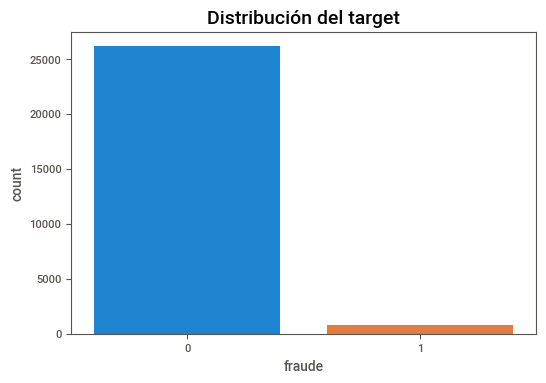

In [ ]:
from matplotlib import pyplot
import seaborn as sns

sns.countplot(x="fraude", data=Data_set)
plt.title('Distribución del target', fontsize=14)
plt.savefig('rpp-ds-challenge/Distribucion_target.pdf')

print('No Fraude', round(Data_set['fraude'].value_counts()[0]/len(Data_set) * 100,2), '%')
print('Fraude', round(Data_set['fraude'].value_counts()[1]/len(Data_set) * 100,2), '% ')

plt.show()

2.- Descriptivo de variables.


2.1. DIVIDIENDO LA MUESTRA EN TRAIN y TEST 70/30

In [13]:
# Dividimos la muestra en train y test.
# No consiero las columnas IDE, primera partición 70% train y 30% test.
train, test = sc.split_df(Data_set.iloc[:,1:], 
                          y = 'fraude',
                          ratio = 0.7,      ## cambiar proporcion de muestra 70 o 80.
                          seed = 1991).values()

Analisis general de estadisticos para la muestra train y Test

In [ ]:
# Exportando el exploratorio de las variables con sweetviz:
my_report_train = sv.analyze(train,target_feat='fraude',pairwise_analysis='off')
my_report_train.show_html('rpp-ds-challenge/EDA_ModeloFraude_Train.html')

                                             |          | [  0%]   00:00 -> (? left)

Report rpp-ds-challenge/EDA_ModeloFraude_Train.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [ ]:
# Exportando el exploratorio de las variables para la muestra del Test:
my_report_test = sv.analyze(test,target_feat='fraude',pairwise_analysis='off')
my_report_test.show_html('rpp-ds-challenge/EDA_ModeloFraude_Test.html')

                                             |          | [  0%]   00:00 -> (? left)

Report rpp-ds-challenge/EDA_ModeloFraude_Test.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


Comparamos ambas muestras elegidas aleatorimente para ver si tienen o mantienen la misma distribución.

In [ ]:
### Comparado abas muestras .
# Exportando el exploratorio de las variables con sweetviz:
my_report_compare = sv.compare([train, "Training Data"], [test, "Test Data"],pairwise_analysis='off')
my_report_compare.show_html('rpp-ds-challenge/EDA_ModeloFraude_Compare.html')

                                             |          | [  0%]   00:00 -> (? left)

Report rpp-ds-challenge/EDA_ModeloFraude_Compare.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


**Tratamiento de variables**

In [14]:
## En base al descriptivo de las variables mostradas, revisamos las variable: Fecha, Establecimineto, genero y ciudad.
## Creamos la variable Dia y elimanos la variable Fecha.

train['Dia'] =pd.to_datetime(train['fecha']).dt.day_name()
test['Dia'] =pd.to_datetime(test['fecha']).dt.day_name()
#  y  eliminamos la variable Fecha
del train['fecha']
del test['fecha']

In [15]:
##### Usamos la función para ver la cantidad de missing que se estan registrando para las variables.
missing_values_table(train)

Your selected dataframe has 15 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
ciudad,8087,42.8
establecimiento,7097,37.6


In [ ]:
##### Usamos la función para ver la cantidad de missing para el test
missing_values_table(test)

Your selected dataframe has 15 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
ciudad,3591,44.4
establecimiento,3022,37.3


In [16]:
## vemos a detalle las categorias de la variable: Establecimiento,ciudad y genero

# Variables a observar:
vars_cat = ['establecimiento','ciudad','genero']
# Revisando distribuciones de las variables categoricas:
for i in vars_cat:
    print("---------------------------------------------------------------------------------------------")
    print(train[i].value_counts(dropna=False)) # Los NaN que salen son missing!

---------------------------------------------------------------------------------------------
NaN            7097
Restaurante    2457
Super          2399
Abarrotes      2375
MPago          2317
Farmacia       2238
Name: establecimiento, dtype: int64
---------------------------------------------------------------------------------------------
NaN            8087
Toluca         2811
Guadalajara    2740
Monterrey      2649
Merida         2596
Name: ciudad, dtype: int64
---------------------------------------------------------------------------------------------
M     9480
F     7474
--    1929
Name: genero, dtype: int64


Para la variable genero, a los registros tienen registrado el valor "--" se le esta considerando como error de registro (Nueva clase para la variable)

In [17]:
train['genero']=np.where(train['genero']=='--','Error registro',train['genero'])
### para la muestra test, tbm.
test['genero']=np.where(test['genero']=='--','Error registro',test['genero'])

Para las demas variables categoricas, tienen valores NAN, o valores Missing, para esos valores se va crear una clase "No registrado" para poder seguir con los analisis bivariados.

In [18]:
# Renombrando los Missing por clase : "No registrado"
for i in vars_cat:
    print("---------------------------------------------------------------------------------------------")
    train[i]=train[i].replace(np.nan,"No registrado") 

---------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------


In [19]:
### verificando .
# Variables a observar:
vars_cat = ['establecimiento','ciudad','genero']
# Revisando distribuciones de las variables categoricas:
for i in vars_cat:
    print("---------------------------------------------------------------------------------------------")
    print(train[i].value_counts(dropna=False)) # Los NaN que salen son missing!

---------------------------------------------------------------------------------------------
No registrado    7097
Restaurante      2457
Super            2399
Abarrotes        2375
MPago            2317
Farmacia         2238
Name: establecimiento, dtype: int64
---------------------------------------------------------------------------------------------
No registrado    8087
Toluca           2811
Guadalajara      2740
Monterrey        2649
Merida           2596
Name: ciudad, dtype: int64
---------------------------------------------------------------------------------------------
M                 9480
F                 7474
Error registro    1929
Name: genero, dtype: int64


In [20]:
### aplicando lo mismo para la muestra test
for i in vars_cat:
    print("---------------------------------------------------------------------------------------------")
    test[i]=test[i].replace(np.nan,"No registrado") 

---------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------


Sacamos algunas variables adicionales de la variable: "Dispostivo"

In [21]:
train["Sistema"]="."
train.loc[train['dispositivo'].str.contains('ANDROID'),"Sistema"] = 'ANDROID'
train.loc[train['dispositivo'].str.contains('WEB'), "Sistema"] = 'WEB'
train.loc[train['dispositivo'].str.contains('%%'),"Sistema"] = '%%'

In [22]:
train["device_score"]=""
train.loc[train['dispositivo'].str.contains('1,'),"device_score"] = '1'
train.loc[train['dispositivo'].str.contains('2,'), "device_score"] = '2'
train.loc[train['dispositivo'].str.contains('3,'),"device_score"] = '3'
train.loc[train['dispositivo'].str.contains('4,'),"device_score"] = '4'
train.loc[train['dispositivo'].str.contains('5,'),"device_score"] = '5'

In [23]:
### lo mismo para el test.

test["Sistema"]="."
test.loc[test['dispositivo'].str.contains('ANDROID'),"Sistema"] = 'ANDROID'
test.loc[test['dispositivo'].str.contains('WEB'), "Sistema"] = 'WEB'
test.loc[test['dispositivo'].str.contains('%%'),"Sistema"] = '%%'

test["device_score"]=""
test.loc[test['dispositivo'].str.contains('1,'),"device_score"] = '1'
test.loc[test['dispositivo'].str.contains('2,'), "device_score"] = '2'
test.loc[test['dispositivo'].str.contains('3,'),"device_score"] = '3'
test.loc[test['dispositivo'].str.contains('4,'),"device_score"] = '4'
test.loc[test['dispositivo'].str.contains('5,'),"device_score"] = '5'

In [24]:
del train['dispositivo']
del test['dispositivo']

Adicionalmente vemos la distribucipon de las variables dcto, cashback

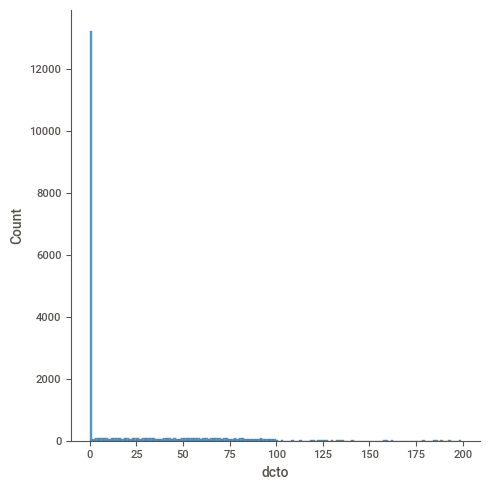

In [ ]:
fig = sns.displot(train['dcto'], kind = 'hist')
plt.savefig('rpp-ds-challenge/Dcto.pdf')
plt.show()

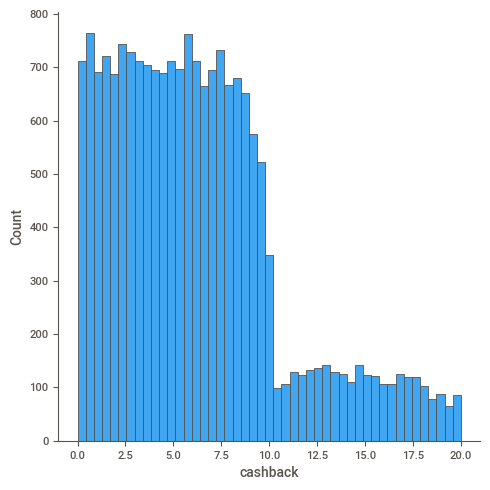

In [ ]:
fig = sns.displot(train['cashback'], kind = 'hist')
plt.savefig('rpp-ds-challenge/cashback.pdf')
plt.show()

Dado que la variable dcto tiene aproximademte 70% e valores iguales a 0, se creara una vairable Bivariada (dcto>0 then 1, dcto=0 then 0)

In [25]:
train['Flag_dcto']=np.where(train['dcto']>0,1,0)
del train['dcto']

In [26]:
#### Lo mismo se considerara para la muestra Test.
test['Flag_dcto']=np.where(test['dcto']>0,1,0)
del test['dcto']

In [27]:
print('----train-----')
print(train.shape)
print('----test-----')
print(test.shape)

----train-----
(18883, 16)
----test-----
(8092, 16)


In [28]:
## Gurdanto train y Test
train.to_csv('rpp-ds-challenge/train_EDA.csv')
test.to_csv('rpp-ds-challenge/test_EDA.csv')

In [ ]:
train=pd.read_csv('rpp-ds-challenge/train_EDA.csv')
del train['Unnamed: 0']

test=pd.read_csv('rpp-ds-challenge/test_EDA.csv')
del test['Unnamed: 0']

Obteniendo una categorización a nivel cliente, para ello nos quedamos con variables a nivel cliente.

In [29]:
###uniendo las bases y obteniendo una base a nivel cliente, considerando las variables a nivel cliente como:
### ID_USER, GENERO, CUIDAD, LINEA_TC, INTERES_TC Y is_prime.
Data_Cliente_train=train.drop_duplicates(['genero','ciudad','linea_tc','interes_tc','is_prime'])[['genero','ciudad','linea_tc','interes_tc','is_prime']]

Data_Cliente_test=test.drop_duplicates(['genero','ciudad','linea_tc','interes_tc','is_prime'])[['genero','ciudad','linea_tc','interes_tc','is_prime']]

Para la categorización de clienes, vamos a considerar la variable 'is_prime' como variable objetivo para un análisis bivariado. (WOE).

In [30]:
## Identificamos algunos insight en base al WOE de cada variable.
## Agrupamos las variables, usando arboles secuenciales para los cortes optimos.
bins = sc.woebin(Data_Cliente_train.iloc[:,:], y = 'is_prime', 
                 min_perc_fine_bin=0.01, 
                 min_perc_coarse_bin=0.05, 
                 stop_limit=0.1, 
                 max_num_bin=5, 
                 method='tree'
                 )

[INFO] creating woe binning ...


{'ciudad': <Figure size 432x288 with 2 Axes>,
 'genero': <Figure size 432x288 with 2 Axes>,
 'interes_tc': <Figure size 432x288 with 2 Axes>,
 'linea_tc': <Figure size 432x288 with 2 Axes>}

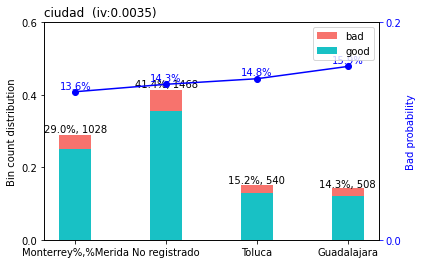

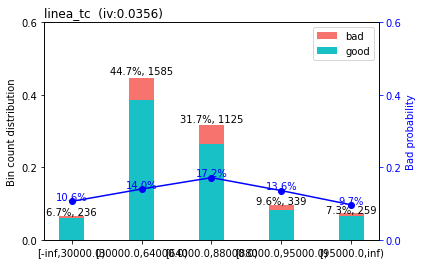

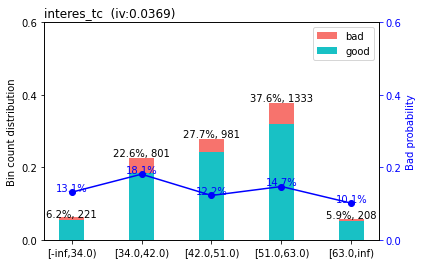

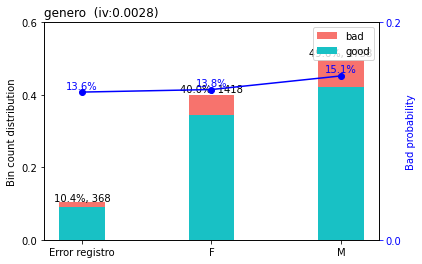

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sc.woebin_plot(bins)

In [ ]:
### por temas de tiempo aplicamos label encoder para las variables categoricas.

le = LabelEncoder()
Data_Cliente_train["genero"] = le.fit_transform(Data_Cliente_train.genero)
Data_Cliente_train["ciudad"] = le.fit_transform(Data_Cliente_train.ciudad)

In [ ]:
features = ["genero", "ciudad", "linea_tc","interes_tc"]
y_train = Data_Cliente_train.pop("is_prime")
X_train = Data_Cliente_train[features]

In [ ]:
y_test = Data_Cliente_test.pop("is_prime")
X_test = Data_Cliente_test[features]

In [ ]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(random_state = 0, max_depth = 3)
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=0)

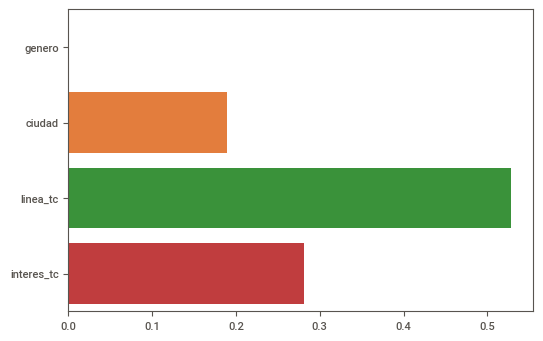

In [ ]:
sns.barplot(y = X_train.columns, x = model.feature_importances_);

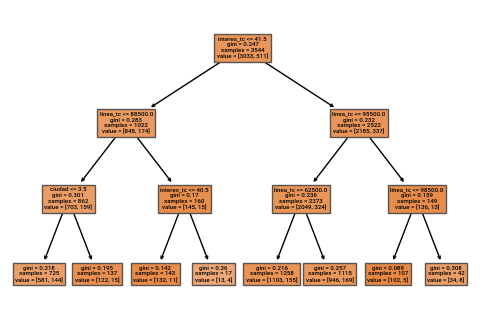

In [ ]:
from io import StringIO
from sklearn import tree
from pydotplus import graph_from_dot_data
import graphviz as gv

fn=Data_Cliente_train.columns

tree.plot_tree(model, 
               feature_names = fn, 
               filled = True);
##fig.savefig('nombre de la imagen.png')

# **Analisis bivariado con WOE**

In [ ]:
## Identificamos algunos insight en base al WOE de cada variable.
## Agrupamos las variables, usando arboles secuenciales para los cortes optimos.
bins = sc.woebin(train.iloc[:,:], y = 'fraude', 
                 min_perc_fine_bin=0.01, 
                 min_perc_coarse_bin=0.05, 
                 stop_limit=0.1, 
                 max_num_bin=5, 
                 method='tree'
                 )

[INFO] creating woe binning ...


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


{'Dia': <Figure size 432x288 with 2 Axes>,
 'Flag_dcto': <Figure size 432x288 with 2 Axes>,
 'Sistema': <Figure size 432x288 with 2 Axes>,
 'cashback': <Figure size 432x288 with 2 Axes>,
 'ciudad': <Figure size 432x288 with 2 Axes>,
 'device_score': <Figure size 432x288 with 2 Axes>,
 'establecimiento': <Figure size 432x288 with 2 Axes>,
 'genero': <Figure size 432x288 with 2 Axes>,
 'hora': <Figure size 432x288 with 2 Axes>,
 'interes_tc': <Figure size 432x288 with 2 Axes>,
 'is_prime': <Figure size 432x288 with 2 Axes>,
 'linea_tc': <Figure size 432x288 with 2 Axes>,
 'monto': <Figure size 432x288 with 2 Axes>,
 'status_txn': <Figure size 432x288 with 2 Axes>,
 'tipo_tc': <Figure size 432x288 with 2 Axes>}

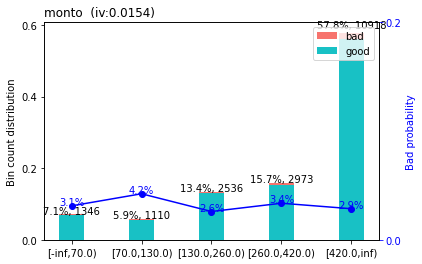

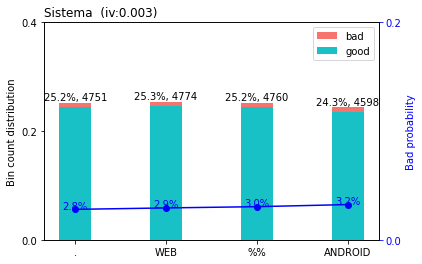

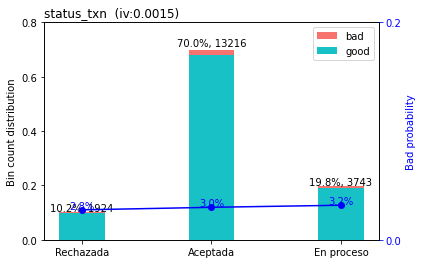

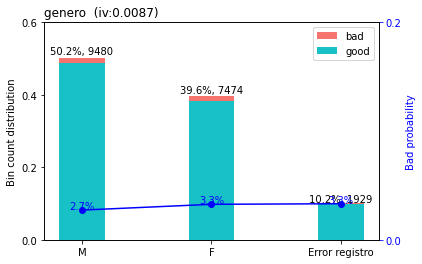

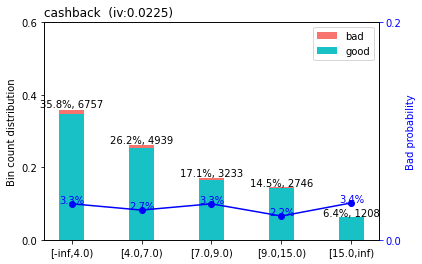

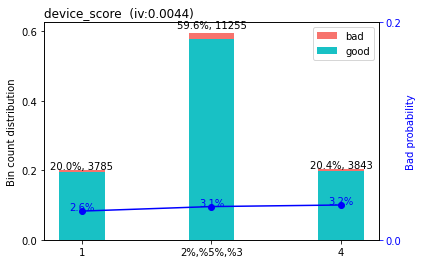

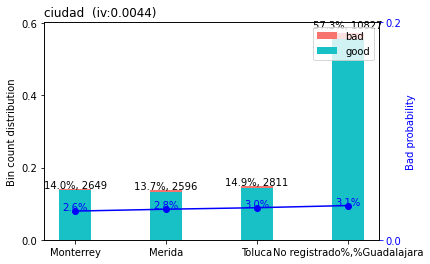

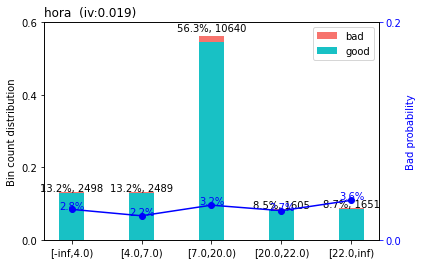

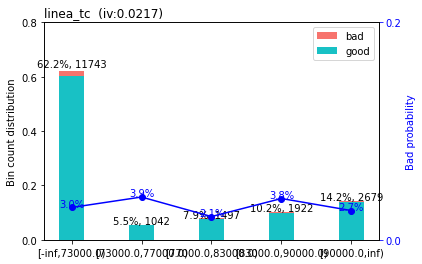

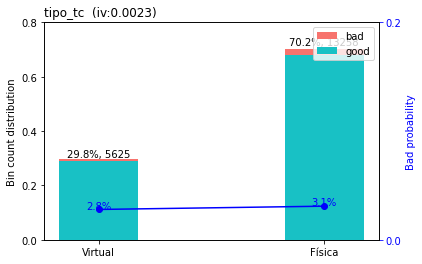

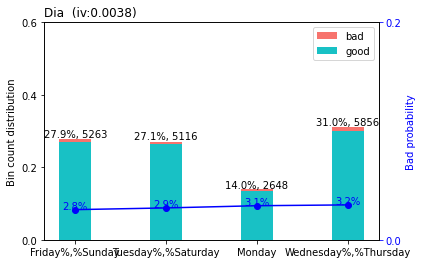

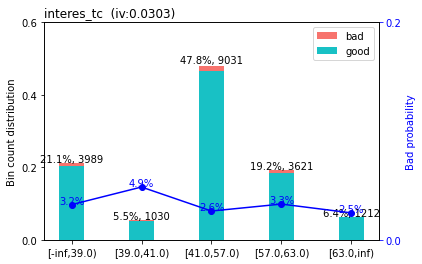

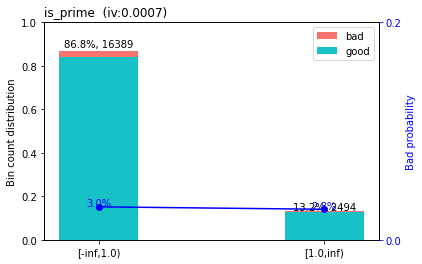

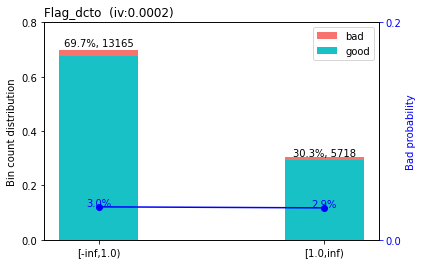

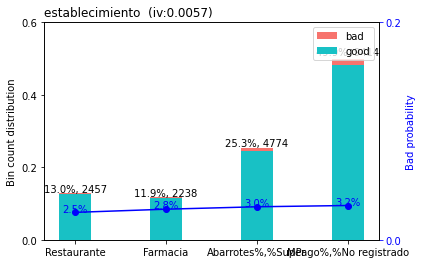

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sc.woebin_plot(bins)

Como hay variables categoricas que no tienen una tendencia explicable, vamos a intertar hacer algunos ajustes (Definir cortes) para poder agrupar esas variable independientemente del IV (Que ya son bajos)
Veamos especificamente las variable "Hora" y "Dia".


-------- 1/15 tipo_tc --------
>>> dt[tipo_tc].describe(): 
count      18883
unique         2
top       Física
freq       13258
Name: tipo_tc, dtype: object 

>>> dt[tipo_tc].value_counts(): 
Física     13258
Virtual     5625
Name: tipo_tc, dtype: int64 

>>> Current breaks:
'Virtual','Física' 



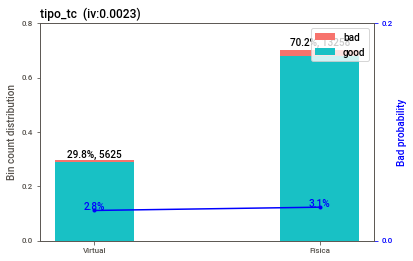

>>> Adjust breaks for (1/15) tipo_tc?
1: next 
2: yes 
3: back
Selection: 1
-------- 2/15 genero --------
>>> dt[genero].describe(): 
count     18883
unique        3
top           M
freq       9480
Name: genero, dtype: object 

>>> dt[genero].value_counts(): 
M                 9480
F                 7474
Error registro    1929
Name: genero, dtype: int64 

>>> Current breaks:
'M','F','Error registro' 



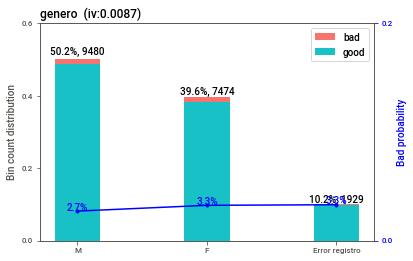

>>> Adjust breaks for (2/15) genero?
1: next 
2: yes 
3: back
Selection: 2
>>> Enter modified breaks: 'M','F%,%Error registro'
[INFO] creating woe binning ...
>>> Current breaks:
'M', 'F%,%Error registro' 



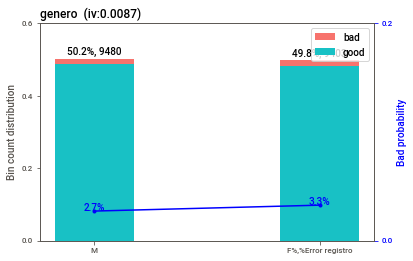

>>> Adjust breaks for (2/15) genero?
1: next 
2: yes 
3: back
Selection: 1
-------- 3/15 device_score --------
>>> dt[device_score].describe(): 
count     18883
unique        5
top           4
freq       3843
Name: device_score, dtype: object 

>>> dt[device_score].value_counts(): 
4    3843
2    3792
5    3788
1    3785
3    3675
Name: device_score, dtype: int64 

>>> Current breaks:
'1','2%,%5%,%3','4' 



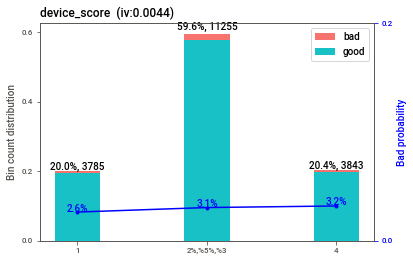

>>> Adjust breaks for (3/15) device_score?
1: next 
2: yes 
3: back
Selection: 2
>>> Enter modified breaks: '1','2%,%5%,%3%,%4' 
[INFO] creating woe binning ...
>>> Current breaks:
'2%,%5%,%3%,%4', '1' 



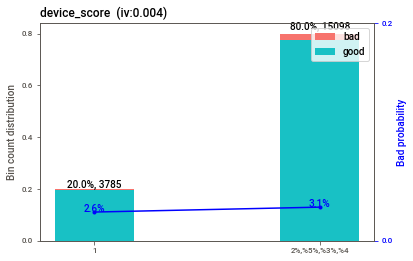

>>> Adjust breaks for (3/15) device_score?
1: next 
2: yes 
3: back
Selection: 1
-------- 4/15 interes_tc --------
>>> dt[interes_tc].describe(): 
count    18883.000000
mean        48.170312
std          9.589709
min         32.000000
25%         40.000000
50%         48.000000
75%         57.000000
max         64.000000
Name: interes_tc, dtype: float64 



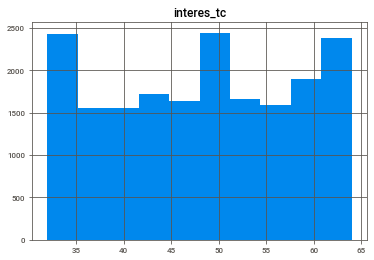

>>> Current breaks:
39.0,41.0,57.0,63.0 



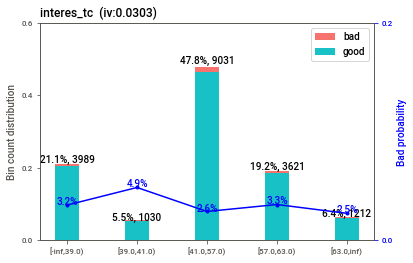

>>> Adjust breaks for (4/15) interes_tc?
1: next 
2: yes 
3: back
Selection: 1
-------- 5/15 Sistema --------
>>> dt[Sistema].describe(): 
count     18883
unique        4
top         WEB
freq       4774
Name: Sistema, dtype: object 

>>> dt[Sistema].value_counts(): 
WEB        4774
%%         4760
.          4751
ANDROID    4598
Name: Sistema, dtype: int64 

>>> Current breaks:
'.','WEB','%%','ANDROID' 



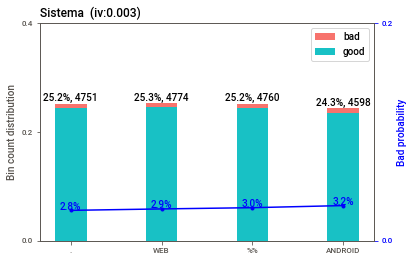

>>> Adjust breaks for (5/15) Sistema?
1: next 
2: yes 
3: back
Selection: 2
>>> Enter modified breaks: '.%,%WEB%,%%%','ANDROID'
[INFO] creating woe binning ...
>>> Current breaks:
'.%,%WEB%,%%%', 'ANDROID' 



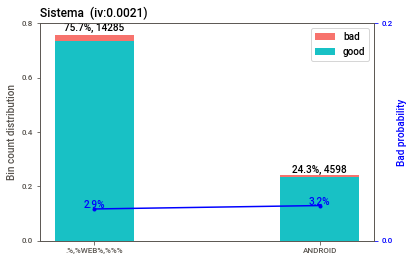

>>> Adjust breaks for (5/15) Sistema?
1: next 
2: yes 
3: back
Selection: 1
-------- 6/15 Dia --------
>>> dt[Dia].describe(): 
count        18883
unique           7
top       Thursday
freq          3225
Name: Dia, dtype: object 

>>> dt[Dia].value_counts(): 
Thursday     3225
Sunday       2665
Monday       2648
Wednesday    2631
Friday       2598
Saturday     2564
Tuesday      2552
Name: Dia, dtype: int64 

>>> Current breaks:
'Friday%,%Sunday','Tuesday%,%Saturday','Monday','Wednesday%,%Thursday' 



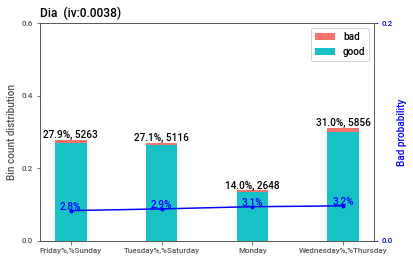

>>> Adjust breaks for (6/15) Dia?
1: next 
2: yes 
3: back
Selection: 2
>>> Enter modified breaks: 'Friday%,%Sunday%,%Saturday','Monday%,%Wednesday%,%Thursday%,%Tuesday'
[INFO] creating woe binning ...
>>> Current breaks:
'Friday%,%Sunday%,%Saturday', 'Monday%,%Wednesday%,%Thursday%,%Tuesday' 



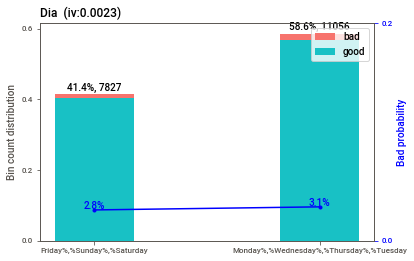

>>> Adjust breaks for (6/15) Dia?
1: next 
2: yes 
3: back
Selection: 1
-------- 7/15 monto --------
>>> dt[monto].describe(): 
count    18883.000000
mean       498.211064
std        288.940643
min          0.017303
25%        246.621536
50%        500.007163
75%        747.289515
max        999.917764
Name: monto, dtype: float64 



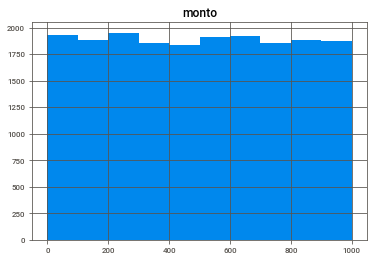

>>> Current breaks:
70.0,130.0,260.0,420.0 



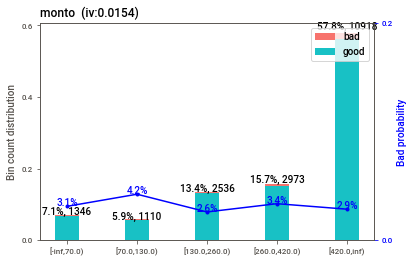

>>> Adjust breaks for (7/15) monto?
1: next 
2: yes 
3: back
Selection: 1
-------- 8/15 status_txn --------
>>> dt[status_txn].describe(): 
count        18883
unique           3
top       Aceptada
freq         13216
Name: status_txn, dtype: object 

>>> dt[status_txn].value_counts(): 
Aceptada      13216
En proceso     3743
Rechazada      1924
Name: status_txn, dtype: int64 

>>> Current breaks:
'Rechazada','Aceptada','En proceso' 



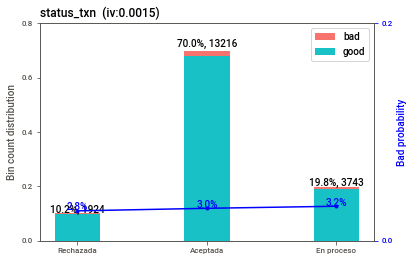

>>> Adjust breaks for (8/15) status_txn?
1: next 
2: yes 
3: back
Selection: 1
-------- 9/15 linea_tc --------
>>> dt[linea_tc].describe(): 
count    18883.000000
mean     62578.509771
std      21905.849466
min      25000.000000
25%      44000.000000
50%      63000.000000
75%      82000.000000
max      99000.000000
Name: linea_tc, dtype: float64 



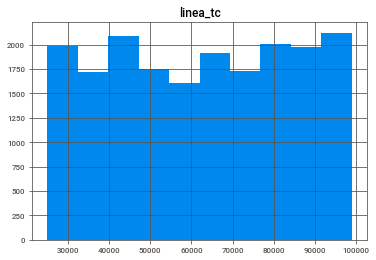

>>> Current breaks:
73000.0,77000.0,83000.0,90000.0 



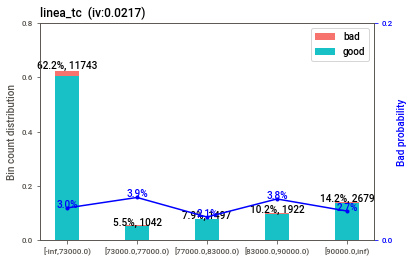

>>> Adjust breaks for (9/15) linea_tc?
1: next 
2: yes 
3: back
Selection: 1
-------- 10/15 ciudad --------
>>> dt[ciudad].describe(): 
count             18883
unique                5
top       No registrado
freq               8087
Name: ciudad, dtype: object 

>>> dt[ciudad].value_counts(): 
No registrado    8087
Toluca           2811
Guadalajara      2740
Monterrey        2649
Merida           2596
Name: ciudad, dtype: int64 

>>> Current breaks:
'Monterrey','Merida','Toluca','No registrado%,%Guadalajara' 



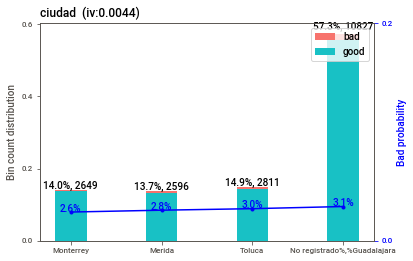

>>> Adjust breaks for (10/15) ciudad?
1: next 
2: yes 
3: back
Selection: 1
-------- 11/15 hora --------
>>> dt[hora].describe(): 
count    18883.000000
mean        11.968490
std          6.655847
min          1.000000
25%          6.000000
50%         12.000000
75%         18.000000
max         23.000000
Name: hora, dtype: float64 



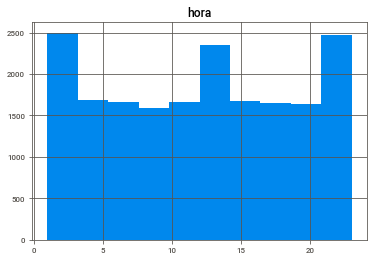

>>> Current breaks:
4.0,7.0,20.0,22.0 



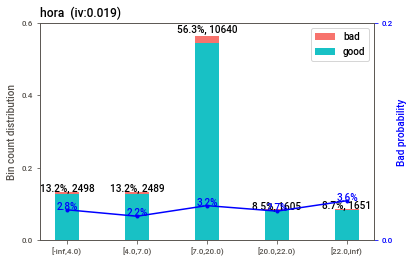

>>> Adjust breaks for (11/15) hora?
1: next 
2: yes 
3: back
Selection: 1
-------- 12/15 establecimiento --------
>>> dt[establecimiento].describe(): 
count             18883
unique                6
top       No registrado
freq               7097
Name: establecimiento, dtype: object 

>>> dt[establecimiento].value_counts(): 
No registrado    7097
Restaurante      2457
Super            2399
Abarrotes        2375
MPago            2317
Farmacia         2238
Name: establecimiento, dtype: int64 

>>> Current breaks:
'Restaurante','Farmacia','Abarrotes%,%Super','MPago%,%No registrado' 



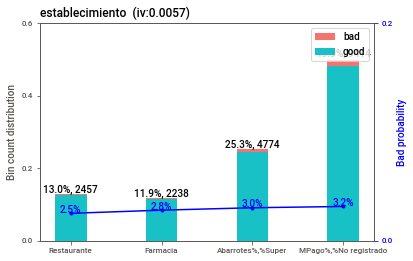

>>> Adjust breaks for (12/15) establecimiento?
1: next 
2: yes 
3: back
Selection: 1
-------- 13/15 is_prime --------
>>> dt[is_prime].describe(): 
count    18883.000000
mean         0.132076
std          0.338583
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: is_prime, dtype: float64 

>>> dt[is_prime].value_counts(): 
0    16389
1     2494
Name: is_prime, dtype: int64 

>>> Current breaks:
1.0 



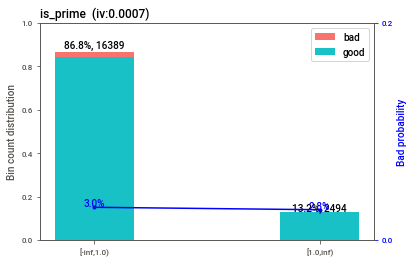

>>> Adjust breaks for (13/15) is_prime?
1: next 
2: yes 
3: back
Selection: 1
-------- 14/15 Flag_dcto --------
>>> dt[Flag_dcto].describe(): 
count    18883.000000
mean         0.302812
std          0.459487
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: Flag_dcto, dtype: float64 

>>> dt[Flag_dcto].value_counts(): 
0    13165
1     5718
Name: Flag_dcto, dtype: int64 

>>> Current breaks:
1.0 



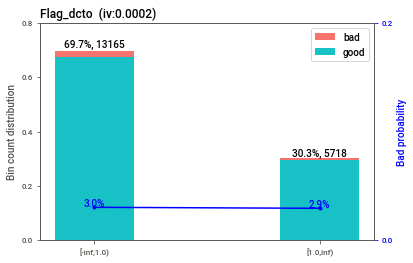

>>> Adjust breaks for (14/15) Flag_dcto?
1: next 
2: yes 
3: back
Selection: 1
-------- 15/15 cashback --------
>>> dt[cashback].describe(): 
count    18883.000000
mean         6.244496
std          4.447955
min          0.000138
25%          2.784490
50%          5.628676
75%          8.505420
max         19.991582
Name: cashback, dtype: float64 



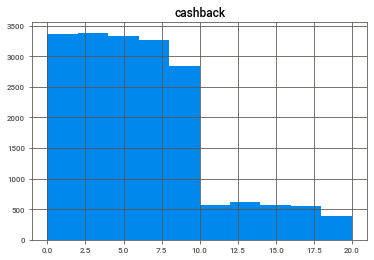

>>> Current breaks:
4.0,7.0,9.0,15.0 



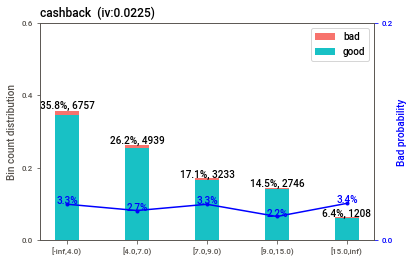

>>> Adjust breaks for (15/15) cashback?
1: next 
2: yes 
3: back
Selection: 1


In [ ]:
breaks_adj = sc.woebin_adj(train, "fraude", bins, adj_all_var = True)

In [ ]:
breaks_adj

"{'Dia': ['Friday%,%Sunday%,%Saturday','Monday%,%Wednesday%,%Thursday%,%Tuesday'], 'Flag_dcto': [1.0], 'Sistema': ['.%,%WEB%,%%%','ANDROID'], 'cashback': [4.0,7.0,9.0,15.0], 'ciudad': ['Monterrey','Merida','Toluca','No registrado%,%Guadalajara'], 'device_score': ['1','2%,%5%,%3%,%4' ], 'establecimiento': ['Restaurante','Farmacia','Abarrotes%,%Super','MPago%,%No registrado'], 'genero': ['M','F%,%Error registro'], 'hora': [4.0,7.0,20.0,22.0], 'interes_tc': [39.0,41.0,57.0,63.0], 'is_prime': [1.0], 'linea_tc': [73000.0,77000.0,83000.0,90000.0], 'monto': [70.0,130.0,260.0,420.0], 'status_txn': ['Rechazada','Aceptada','En proceso'], 'tipo_tc': ['Virtual','Física']}"

In [ ]:
#### Guaramos los cortes definidos por iv y conversando con el negocio.
breaks_adj={'Dia': ['Friday%,%Sunday%,%Saturday','Monday%,%Wednesday%,%Thursday%,%Tuesday'], 'Flag_dcto': [1.0], 'Sistema': ['.%,%WEB%,%%%','ANDROID'], 'cashback': [4.0,7.0,9.0,15.0], 'ciudad': ['Monterrey','Merida','Toluca','No registrado%,%Guadalajara'], 'device_score': ['1','2%,%5%,%3%,%4' ], 'establecimiento': ['Restaurante','Farmacia','Abarrotes%,%Super','MPago%,%No registrado'], 'genero': ['M','F%,%Error registro'], 'hora': [4.0,7.0,20.0,22.0], 'interes_tc': [39.0,41.0,57.0,63.0], 'is_prime': [1.0], 'linea_tc': [73000.0,77000.0,83000.0,90000.0], 'monto': [70.0,130.0,260.0,420.0], 'status_txn': ['Rechazada','Aceptada','En proceso'], 'tipo_tc': ['Virtual','Física']}

Aplicando los cortes a la base train y test.

In [ ]:
bins_adj = sc.woebin(train, y="fraude", breaks_list=breaks_adj) 
train_woe = sc.woebin_ply(train, bins_adj) 
test_woe = sc.woebin_ply(test, bins_adj) 

[INFO] creating woe binning ...
[INFO] converting into woe values ...
[INFO] converting into woe values ...


In [ ]:
print('----train_woe-----')
print(train_woe.shape)
print('----test_woe-----')
print(test_woe.shape)

----train_woe-----
(18883, 16)
----test_woe-----
(8092, 16)


Evaluando importancia de las variables mediante IV.

In [ ]:
Vi_train=sc.iv(train_woe, 'fraude')
Vi_train

,variable,info_value
2,interes_tc_woe,0.030263
11,cashback_woe,0.022485
7,linea_tc_woe,0.021738
13,hora_woe,0.018965
14,monto_woe,0.015445
12,genero_woe,0.008725
1,establecimiento_woe,0.005701
4,ciudad_woe,0.004358
8,device_score_woe,0.004029
9,Dia_woe,0.002330


In [ ]:
######### Eliminado variales por bajo IV (menor a 0.01)
Variables_menos_importantes=Vi_train.loc[Vi_train['info_value']<0.01,'variable']

In [ ]:
#   list(Variables_menos_importantes)
Variables_menos_importantes=['genero_woe','establecimiento_woe','ciudad_woe','device_score_woe','Dia_woe','tipo_tc_woe','Sistema_woe','status_txn_woe','is_prime_woe','Flag_dcto_woe']

In [ ]:
for i in list(Variables_menos_importantes):
  
    del train_woe[i]

In [ ]:
### para la muestra test.
for i in list(Variables_menos_importantes):
    del test_woe[i]

In [ ]:
print('----train_woe-----')
print(train_woe.shape)
print('----test_woe-----')
print(test_woe.shape)

----train_woe-----
(18883, 6)
----test_woe-----
(8092, 6)


In [ ]:
### Comparado ambas muestras con sus valores WOE
# Exportando el exploratorio de las variables con sweetviz:
my_report_compare = sv.compare([train_woe, "Training Data"], [test_woe, "Test Data"],pairwise_analysis='off')
my_report_compare.show_html('rpp-ds-challenge/EDA_ModeloFraude_CompareWOE.html')

                                             |          | [  0%]   00:00 -> (? left)

Report rpp-ds-challenge/EDA_ModeloFraude_CompareWOE.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


Evaluando correlación de las variables finalistas (Más importantes)

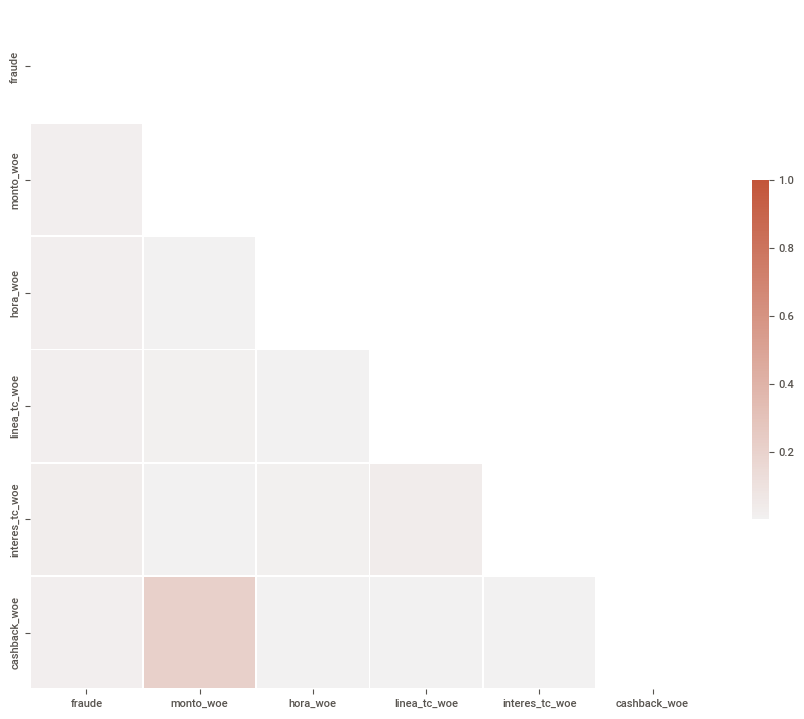

In [ ]:
corr = train_woe.corr()
corr = np.abs(corr)
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
corr

,fraude,monto_woe,hora_woe,linea_tc_woe,interes_tc_woe,cashback_woe
fraude,1.000000,0.022192,0.022698,0.025126,0.031463,0.024615
monto_woe,0.022192,1.000000,0.006260,0.013710,0.003001,0.213678
hora_woe,0.022698,0.006260,1.000000,0.006715,0.012588,0.007340
linea_tc_woe,0.025126,0.013710,0.006715,1.000000,0.035530,0.002372
interes_tc_woe,0.031463,0.003001,0.012588,0.035530,1.000000,0.005668
cashback_woe,0.024615,0.213678,0.007340,0.002372,0.005668,1.000000


In [ ]:
train_woe.describe()

,fraude,monto_woe,hora_woe,linea_tc_woe,interes_tc_woe,cashback_woe
count,18883.000000,18883.000000,18883.000000,18883.000000,18883.000000,18883.000000
mean,0.030027,-0.007013,-0.009151,-0.010219,-0.013603,-0.010888
std,0.170666,0.118780,0.142600,0.147653,0.164155,0.155900
min,0.000000,-0.147148,-0.314787,-0.348704,-0.198595,-0.326293
25%,0.000000,-0.051001,-0.071157,-0.010599,-0.129963,-0.096758
50%,0.000000,-0.051001,0.061175,-0.010599,-0.129963,0.100490
75%,0.000000,0.039649,0.061175,-0.010599,0.076561,0.102195
max,1.000000,0.356468,0.197398,0.279988,0.499641,0.126551


***Modelo regresión logistica.***

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
np.random.seed(1991)
fraude_log= LogisticRegressionCV(cv = 3,    
                                   
                                     random_state=1991, # Semilla
                                     max_iter=500, # Maximum iterations
                                     verbose=1, 
                                     n_jobs = 2,     
                                     refit = True)

In [ ]:
train_woe.columns

Index(['fraude', 'monto_woe', 'hora_woe', 'linea_tc_woe', 'interes_tc_woe',
       'cashback_woe'],
      dtype='object')

In [ ]:
fraude_log.fit(X = train_woe.iloc[:, 1:], # All rows and from the second var to end
                    y = train_woe['fraude'] # The target
                   )

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:    0.3s finished


LogisticRegressionCV(cv=3, max_iter=500, n_jobs=2, random_state=1991, verbose=1)

In [ ]:
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve

# Apply the model to the test set.
rf_pred_class_train = fraude_log.predict(train_woe.iloc[:, 1:])
rf_probs_train = fraude_log.predict_proba(train_woe.iloc[:, 1:])

rf_pred_class_test = fraude_log.predict(test_woe.iloc[:, 1:])
rf_probs_test = fraude_log.predict_proba(test_woe.iloc[:, 1:])

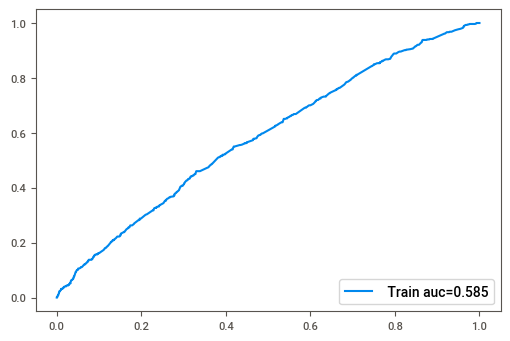

In [ ]:
# ROC, train
fpr, tpr, thresholds = roc_curve(train_woe['fraude'], rf_probs_train[:,1])
auc_train = np.round(roc_auc_score(y_true = train['fraude'], 
                             y_score = rf_probs_train[:,1]),
              decimals = 3)
plt.plot(fpr,tpr,label=" Train auc="+str(auc_train))
plt.legend(loc=4)
plt.savefig('rpp-ds-challenge/Logig_AUC_Train.pdf')
plt.show()

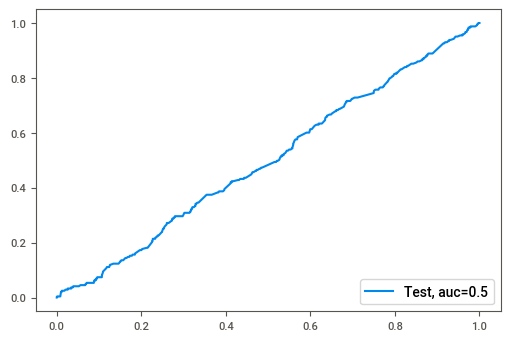

In [ ]:
fpr, tpr, thresholds = roc_curve(test_woe['fraude'], rf_probs_test[:,1])
auc = np.round(roc_auc_score(y_true = test['fraude'], 
                             y_score = rf_probs_test[:,1]),
              decimals = 3)
plt.plot(fpr,tpr,label="Test, auc="+str(auc))
plt.legend(loc=4)
plt.savefig('rpp-ds-challenge/Logig_AUC_Test.pdf')
plt.show()

In [ ]:
### Guardando modelo en un objeto.
import joblib

joblib_filename = "rpp-ds-challenge/modelo_logit.joblib" #fullpath
joblib.dump(fraude_log, joblib_filename)

['rpp-ds-challenge/modelo_logit.joblib']

***Xboost***


Utilizaremos otro modelo de machine learning para poder comparar los resultados, para ello agruparemos algunas clases de las variables categoricas.
Iniciamos validanto la cantidad de clases por categoria tanto para la muestra de entrenamiento y prueba son iguales, comenzamos con el agrupamiento de clases solo para las variables Hora y Dia, ya que son las variables con mayor cantidad de clases.

In [ ]:
train.columns

Index(['genero', 'monto', 'hora', 'establecimiento', 'ciudad', 'tipo_tc',
       'linea_tc', 'interes_tc', 'status_txn', 'is_prime', 'cashback',
       'fraude', 'Dia', 'Sistema', 'device_score', 'Flag_dcto'],
      dtype='object')

In [ ]:
vars_cat=['Dia','hora']

# Revisando distribuciones de las variables categoricas tanto en la muestra de Train y Test, con el obejtivo de poder validar que amabas muestras tienen la misma cantidad de clases.
for i in vars_cat:
    print("---------------------------------------------------------------------------------------------")
    print(train[i].name)
    print(train[i].nunique())
    print(train[i].value_counts(dropna=False))

---------------------------------------------------------------------------------------------
Dia
7
Thursday     3225
Sunday       2665
Monday       2648
Wednesday    2631
Friday       2598
Saturday     2564
Tuesday      2552
Name: Dia, dtype: int64
---------------------------------------------------------------------------------------------
hora
23
7     860
22    855
15    854
19    854
5     842
10    841
4     840
3     838
18    837
2     830
1     830
11    827
21    821
16    817
17    810
8     808
6     807
14    805
23    796
20    784
9     782
12    782
13    763
Name: hora, dtype: int64


In [ ]:
### validando en el Test.

vars_cat=['Dia','hora']

# Revisando distribuciones de las variables categoricas tanto en la muestra de Train y Test, con el obejtivo de poder validar que amabas muestras tienen la misma cantidad de clases.
for i in vars_cat:
    print("---------------------------------------------------------------------------------------------")
    print(test[i].name)
    print(test[i].nunique())
    print(test[i].value_counts(dropna=False))

---------------------------------------------------------------------------------------------
Dia
7
Thursday     1388
Saturday     1152
Wednesday    1145
Tuesday      1127
Sunday       1115
Friday       1091
Monday       1074
Name: Dia, dtype: int64
---------------------------------------------------------------------------------------------
hora
23
6     395
21    378
18    371
16    370
7     367
14    365
5     363
10    361
1     360
22    356
12    355
15    353
19    350
13    348
17    340
8     338
4     336
11    335
20    334
23    333
2     332
9     327
3     325
Name: hora, dtype: int64


In [ ]:
### Generamos nuevas variables, agrupando clases de las variables Hora, Dia.
train['Hora_Agrup']=np.where(train.hora<13,'Mañana',(np.where(((train.hora>=13) & (train.hora<18)),'Tarde','Noche')))

train['Dia_Agrup']=np.where(((train.Dia=='Friday') | (train.Dia=='Sunday') | (train.Dia=='Saturday')),'Fin_semana','Dias_semana')

In [ ]:
test['Hora_Agrup']=np.where(test.hora<13,'Mañana',(np.where(((test.hora>=13) & (test.hora<18)),'Tarde','Noche')))

test['Dia_Agrup']=np.where(((test.Dia=='Friday') | (test.Dia=='Sunday') | (test.Dia=='Saturday')),'Fin_semana','Dias_semana')

In [ ]:
## Para Train
del train['hora']
del train['Dia']
## Para Test
del test['hora']
del test['Dia']

KeyError: ignored

In [ ]:
print(train.shape);
print(test.shape);

(18883, 16)
(8092, 16)


In [ ]:
train.dtypes

genero              object
monto              float64
establecimiento     object
ciudad              object
tipo_tc             object
linea_tc             int64
interes_tc           int64
status_txn          object
is_prime             int64
cashback           float64
fraude               int64
Sistema             object
device_score        object
Flag_dcto            int64
Hora_Agrup          object
Dia_Agrup           object
dtype: object

A las variables categoricas se le realiza una codificacion ficticia. Aplicamos Mean Encoding.

In [ ]:
categorias_niveles=['genero','establecimiento','ciudad','tipo_tc','status_txn','Sistema','device_score','Hora_Agrup','Dia_Agrup']
array=[]
Tabla_Mean_Encoding=[]
target='fraude'

In [ ]:
for variable in categorias_niveles:
  print(variable)
  dict=train.groupby([variable])[target].mean().to_dict()
  array=pd.DataFrame(dict.items(),columns=['Nivel','Mean_target']).sort_values(by='Mean_target',ascending=False)
  array['Variable']=variable
  array.groupby(['Mean_target'])['Nivel'].apply(lambda grp: list(grp.value_counts().index)).to_dict
  Tabla_Mean_Encoding=pd.concat([array,pd.DataFrame(Tabla_Mean_Encoding)])

  train[variable]=train[variable].map(dict)
  # reemplazar en test
  test[variable]=test[variable].map(dict)

genero
establecimiento
ciudad
tipo_tc
status_txn
Sistema
device_score
Hora_Agrup
Dia_Agrup


In [ ]:
Tabla_Mean_Encoding

,Nivel,Mean_target,Variable
0,Dias_semana,0.031205,Dia_Agrup
1,Fin_semana,0.028363,Dia_Agrup
1,Noche,0.033556,Hora_Agrup
2,Tarde,0.031366,Hora_Agrup
0,Mañana,0.027713,Hora_Agrup
3,4,0.032006,device_score
2,3,0.031020,device_score
4,5,0.030623,device_score
1,2,0.030063,device_score
0,1,0.026420,device_score


In [ ]:
## Definiendo parametros.
from xgboost import XGBClassifier

XGB_Fraude = XGBClassifier(max_depth=2,                 
                            learning_rate=0.1,            
                            n_estimators=50,             
                            verbosity=1,                  
                            objective='binary:logistic',  
                            booster='gbtree',             
                            n_jobs=2,                   
                            gamma=0.001,                  
                            subsample=0.632,             
                            colsample_bytree=1,         
                            colsample_bylevel=1,          
                            colsample_bynode=1,          
                            reg_alpha=1,                  
                            reg_lambda=0,                 
                            scale_pos_weight=3,   ###balanceamos la muestra           
                            base_score=0.5,              
                            random_state=1991,       
                            missing=None,                
                            #tree_method='gpu_hist',      
                            #gpu_id=0                      
                            )

In [ ]:
param_grid = {'n_estimators': [50, 100, 150],
                   'max_depth': [2, 3, 4],
                 'learning_rate' : [0.01, 0.05, 0.1, 0.15],
             'scale_pos_weight' : [3,4,6]
                  }

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define grid search object.
GridXGB = GridSearchCV(XGB_Fraude,       
                       param_grid,          
                       cv = 3,              
                       scoring = 'roc_auc', 
                       n_jobs = 2,          
                       refit = False,       
                       verbose = 1        
                      )

In [ ]:
train = train.reindex(columns=['genero', 'monto', 'establecimiento', 'ciudad', 'tipo_tc', 'linea_tc',
       'interes_tc', 'status_txn', 'is_prime', 'cashback', 'Sistema',
       'device_score', 'Flag_dcto', 'Hora_Agrup', 'Dia_Agrup','fraude'])
print(train)

         genero       monto  establecimiento  ...  Hora_Agrup  Dia_Agrup  fraude
1      0.032647   88.719243         0.031563  ...    0.027713   0.031205       0
2      0.032647  790.037653         0.031563  ...    0.027713   0.028363       0
3      0.032647  767.005387         0.031506  ...    0.027713   0.028363       0
4      0.032647  254.171053         0.031563  ...    0.027713   0.031205       0
5      0.032647   37.003747         0.031563  ...    0.027713   0.031205       0
...         ...         ...              ...  ...         ...        ...     ...
26968  0.027321  683.979525         0.031563  ...    0.027713   0.031205       0
26970  0.027321  746.192089         0.031563  ...    0.031366   0.031205       0
26971  0.027321  941.804966         0.031563  ...    0.031366   0.031205       0
26973  0.027321   24.182665         0.031563  ...    0.031366   0.031205       0
26974  0.027321  517.209272         0.031506  ...    0.033556   0.028363       0

[18883 rows x 16 columns]


In [ ]:
test = test.reindex(columns=['genero', 'monto', 'establecimiento', 'ciudad', 'tipo_tc', 'linea_tc',
       'interes_tc', 'status_txn', 'is_prime', 'cashback', 'Sistema',
       'device_score', 'Flag_dcto', 'Hora_Agrup', 'Dia_Agrup','fraude'])
print(test)

         genero       monto  establecimiento  ...  Hora_Agrup  Dia_Agrup  fraude
0      0.032647  608.345634         0.030429  ...    0.033556   0.031205       0
8      0.032647  911.797804         0.030316  ...    0.027713   0.028363       0
9      0.032647  160.095187         0.031563  ...    0.027713   0.031205       0
17     0.032647   62.607836         0.028150  ...    0.027713   0.028363       0
18     0.033178  277.176524         0.025234  ...    0.027713   0.031205       0
...         ...         ...              ...  ...         ...        ...     ...
26958  0.027321   61.440649         0.031563  ...    0.027713   0.028363       0
26959  0.027321   18.954647         0.031563  ...    0.033556   0.028363       0
26966  0.027321  378.006870         0.031563  ...    0.027713   0.028363       0
26969  0.027321  861.281467         0.028150  ...    0.027713   0.028363       0
26972  0.027321  251.189885         0.031563  ...    0.027713   0.031205       0

[8092 rows x 16 columns]


In [ ]:
GridXGB.fit(train.iloc[:, :-1],train['fraude'])

Fitting 3 folds for each of 108 candidates, totalling 324 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(gamma=0.001, max_depth=2, n_estimators=50,
                                     n_jobs=2, random_state=1991, reg_alpha=1,
                                     reg_lambda=0, scale_pos_weight=3,
                                     subsample=0.632),
             n_jobs=2,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.15],
                         'max_depth': [2, 3, 4], 'n_estimators': [50, 100, 150],
                         'scale_pos_weight': [3, 4, 6]},
             refit=False, scoring='roc_auc', verbose=1)

In [ ]:
# Mostrando los mejores parametros.
print('The best AUC is %.3f' % GridXGB.best_score_)
GridXGB.best_params_

The best AUC is 0.510


{'learning_rate': 0.01,
 'max_depth': 2,
 'n_estimators': 50,
 'scale_pos_weight': 3}

In [ ]:
XGB_Fraude=XGBClassifier(max_depth=GridXGB.best_params_.get('max_depth'), 
                            learning_rate=GridXGB.best_params_.get('learning_rate'), 
                            n_estimators=GridXGB.best_params_.get('n_estimators'), 
                            verbosity=1,                  
                            objective='binary:logistic',  
                            booster='gbtree',             
                            #n_jobs=4,                    
                            gamma=0.001,                  
                            subsample=0.632,              
                            colsample_bytree=1,           
                            colsample_bylevel=1,          
                            colsample_bynode=1,           
                            reg_alpha=1,                  
                            reg_lambda=0,                 
                            scale_pos_weight=GridXGB.best_params_.get('scale_pos_weight'),           # Equilibrio de ponderaciones positivas y negativas
                            base_score=0.5,               
                            random_state=1991,        
                            missing=None                   
                            )


In [ ]:
XGB_Fraude.fit(train.iloc[:, :-1], train['fraude'])

XGBClassifier(gamma=0.001, learning_rate=0.01, max_depth=2, n_estimators=50,
              random_state=1991, reg_alpha=1, reg_lambda=0, scale_pos_weight=3,
              subsample=0.632)

In [ ]:
import joblib

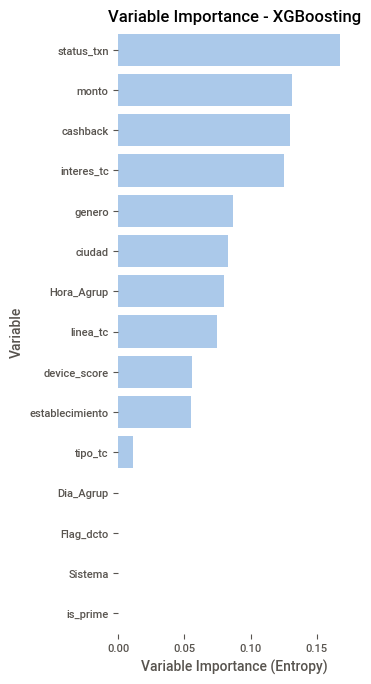

In [ ]:
# Plot variable importance
importances = XGB_Fraude.feature_importances_
indices = np.argsort(importances)[::-1] 

f, ax = plt.subplots(figsize=(3, 8))
plt.title("Variable Importance - XGBoosting")
sns.set_color_codes("pastel")
sns.barplot(y=[train.iloc[:, :-1].columns[i] for i in indices], x=importances[indices], 
            label="Total", color="b")
plt.savefig('rpp-ds-challenge/Importancia_variables.pdf')
ax.set(ylabel="Variable",
       xlabel="Variable Importance (Entropy)")
sns.despine(left=True, bottom=True)

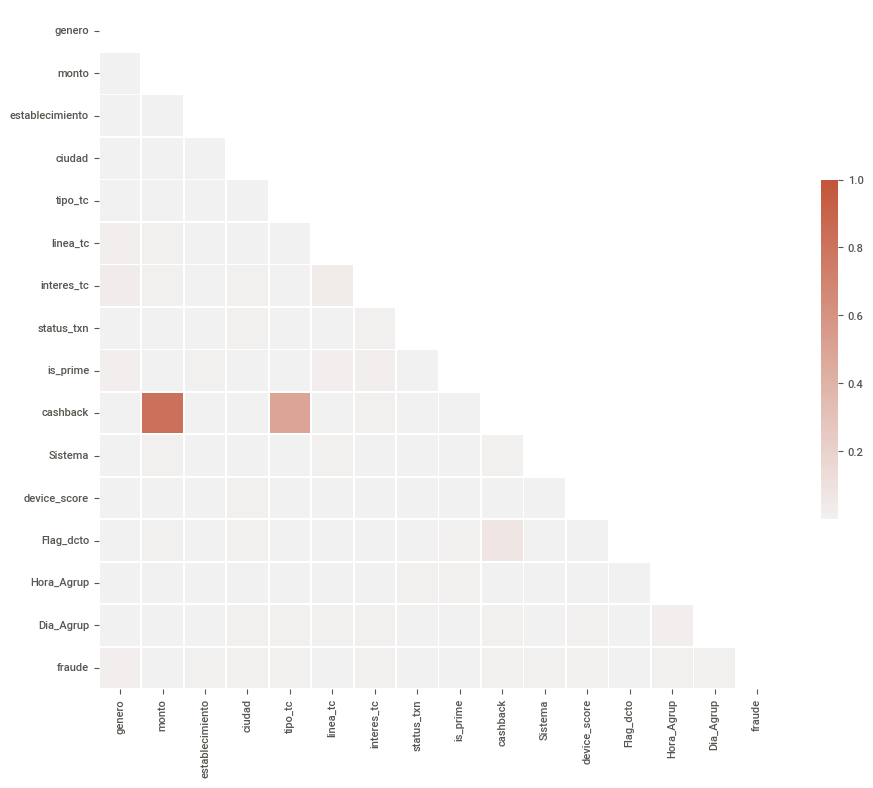

In [ ]:
### atriz de correlación
corr = train.corr()
corr = np.abs(corr)


mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
corr

,genero,monto,establecimiento,ciudad,tipo_tc,linea_tc,interes_tc,status_txn,is_prime,cashback,Sistema,device_score,Flag_dcto,Hora_Agrup,Dia_Agrup,fraude
genero,1.000000,0.003904,0.004836,0.001965,0.001090,0.022341,0.032391,0.007172,0.020288,0.002295,0.003990,0.001097,0.002986,0.006031,0.004291,0.015947
monto,0.003904,1.000000,0.002546,0.000395,0.004501,0.009807,0.010558,0.002895,0.004008,0.815196,0.014479,0.004207,0.012111,0.003660,0.000949,0.007255
establecimiento,0.004836,0.002546,1.000000,0.006342,0.004654,0.002016,0.002853,0.003147,0.009285,0.003250,0.001760,0.005823,0.004523,0.005152,0.001538,0.012557
ciudad,0.001965,0.000395,0.006342,1.000000,0.001142,0.004332,0.012574,0.008825,0.007701,0.001190,0.005074,0.012338,0.013330,0.006842,0.012521,0.011223
tipo_tc,0.001090,0.004501,0.004654,0.001142,1.000000,0.001268,0.000966,0.007051,0.002370,0.497874,0.001390,0.003153,0.007229,0.006523,0.010916,0.008076
linea_tc,0.022341,0.009807,0.002016,0.004332,0.001268,1.000000,0.039369,0.002993,0.021373,0.007216,0.009250,0.005659,0.005478,0.003036,0.013461,0.001488
interes_tc,0.032391,0.010558,0.002853,0.012574,0.000966,0.039369,1.000000,0.009651,0.019259,0.011817,0.004133,0.001145,0.000423,0.001595,0.008822,0.009888
status_txn,0.007172,0.002895,0.003147,0.008825,0.007051,0.002993,0.009651,1.000000,0.006100,0.002961,0.005565,0.000718,0.004764,0.010517,0.002725,0.006573
is_prime,0.020288,0.004008,0.009285,0.007701,0.002370,0.021373,0.019259,0.006100,1.000000,0.001585,0.004914,0.007505,0.010140,0.015425,0.000075,0.004479
cashback,0.002295,0.815196,0.003250,0.001190,0.497874,0.007216,0.011817,0.002961,0.001585,1.000000,0.015034,0.001055,0.081651,0.005643,0.008616,0.008638


In [ ]:
### Elimando variables que no entraran en el modelo por su alta correlación con otro variable y por que tienen bala importancia.
## Elimanos las variable "cashback" ya que esta correlacionada con la variable "Monto" y se encuentra en el top 3 de importancia. 
var_no_consideradas=['cashback','Dia_Agrup','Sistema','is_prime','Flag_dcto']
train=train.drop(var_no_consideradas,axis=1)
test=test.drop(var_no_consideradas,axis=1)

In [ ]:
print(train.shape);
print(test.shape);

(18883, 11)
(8092, 11)


Volvemos a entrenar el modelo.

In [ ]:
## Definiendo parametros.
from xgboost import XGBClassifier

XGB_Fraude = XGBClassifier(max_depth=2,                 
                            learning_rate=0.1,            
                            n_estimators=50,             
                            verbosity=1,                  
                            objective='binary:logistic',  
                            booster='gbtree',             
                            n_jobs=2,                   
                            gamma=0.001,                  
                            subsample=0.632,             
                            colsample_bytree=1,         
                            colsample_bylevel=1,          
                            colsample_bynode=1,          
                            reg_alpha=1,                  
                            reg_lambda=0,                 
                            scale_pos_weight=3,   ###balanceamos la muestra           
                            base_score=0.5,              
                            random_state=1991,       
                            missing=None,                
                            #tree_method='gpu_hist',      
                            #gpu_id=0                      
                            )

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define grid search object.
GridXGB = GridSearchCV(XGB_Fraude,       
                       param_grid,          
                       cv = 3,              
                       scoring = 'roc_auc', 
                       n_jobs = 2,          
                       refit = False,       
                       verbose = 1        
                      )

In [ ]:
GridXGB.fit(train.iloc[:, :-1],train['fraude'])

Fitting 3 folds for each of 108 candidates, totalling 324 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(gamma=0.001, max_depth=2, n_estimators=50,
                                     n_jobs=2, random_state=1991, reg_alpha=1,
                                     reg_lambda=0, scale_pos_weight=3,
                                     subsample=0.632),
             n_jobs=2,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.15],
                         'max_depth': [2, 3, 4], 'n_estimators': [50, 100, 150],
                         'scale_pos_weight': [3, 4, 6]},
             refit=False, scoring='roc_auc', verbose=1)

In [ ]:
# Mostrando los mejores parametros.
print('The best AUC is %.3f' % GridXGB.best_score_)
GridXGB.best_params_

The best AUC is 0.510


{'learning_rate': 0.01,
 'max_depth': 2,
 'n_estimators': 150,
 'scale_pos_weight': 3}

Los indicadores no mejoraron.

In [ ]:
XGB_Fraude=XGBClassifier(max_depth=GridXGB.best_params_.get('max_depth'), 
                            learning_rate=GridXGB.best_params_.get('learning_rate'), 
                            n_estimators=GridXGB.best_params_.get('n_estimators'), 
                            verbosity=1,                  
                            objective='binary:logistic',  
                            booster='gbtree',             
                            #n_jobs=4,                    
                            gamma=0.001,                  
                            subsample=0.632,              
                            colsample_bytree=1,           
                            colsample_bylevel=1,          
                            colsample_bynode=1,           
                            reg_alpha=1,                  
                            reg_lambda=0,                 
                            scale_pos_weight=GridXGB.best_params_.get('scale_pos_weight'),           # Equilibrio de ponderaciones positivas y negativas
                            base_score=0.5,               
                            random_state=1991,        
                            missing=None                   
                            )


In [ ]:
#### Guardando el modelo en objeto
#from sklearn.externals import joblib

# Guardando el objeto del modelo
joblib_filename = "rpp-ds-challenge/modelo_xgboost.joblib" #fullpath
joblib.dump(XGB_Fraude, joblib_filename)

['rpp-ds-challenge/modelo_xgboost.joblib']

**### Modelamiento - LightGBM**

In [ ]:
train = train.reindex(columns=['genero','monto', 'establecimiento', 'ciudad', 'tipo_tc', 'linea_tc',
       'interes_tc', 'status_txn', 'is_prime', 'cashback', 
       'Flag_dcto', 'Hora_Agrup', 'Dia_Agrup', 'Dispositivo_Agrup','fraude'])
print(train)

         genero       monto  ...  Dispositivo_Agrup  fraude
1      0.032647   88.719243  ...           0.032789       0
2      0.032647  790.037653  ...           0.033547       0
3      0.032647  767.005387  ...           0.026859       0
4      0.032647  254.171053  ...           0.032789       0
5      0.032647   37.003747  ...           0.032789       0
...         ...         ...  ...                ...     ...
26968  0.027321  683.979525  ...           0.026859       0
26970  0.027321  746.192089  ...           0.032789       0
26971  0.027321  941.804966  ...           0.026859       0
26973  0.027321   24.182665  ...           0.032789       0
26974  0.027321  517.209272  ...           0.032789       0

[18883 rows x 15 columns]


In [ ]:
# Particionando la muestra.
train_x, valid_x, train_y, valid_y = train_test_split(train.iloc[:,:-1],
                                                      train["fraude"],
                                                      test_size=0.3,
                                                      shuffle=True,
                                                      random_state=1991,
                                                      stratify=train["fraude"])

In [ ]:
# Parametros del LightGBM
param = lgbm.LGBMClassifier(
        n_estimators=300,
        learning_rate=0.01,
        boosting_type= 'gbdt',
        objective='binary',
        colsample_bytree=.8,
        subsample=.8,
        max_depth=10,
        lambda_l1=1
        )

# Entrenamiento:
lgbm_model = param.fit(train_x, train_y, 
                eval_set= [(train_x, train_y), (valid_x, valid_y)], 
                #categorical_feature = vars_cat,
                eval_metric=['auc'], 
                verbose=25,
                early_stopping_rounds=15
               )

Training until validation scores don't improve for 15 rounds.
Early stopping, best iteration is:
[1]	training's auc: 0.649742	training's binary_logloss: 0.134673	valid_1's auc: 0.495208	valid_1's binary_logloss: 0.134777


In [ ]:
vars_in=train.iloc[:,:-1].columns

In [ ]:
# Importancia de variables:
feature_importance_df = pd.DataFrame()
feature_importance_df["Variable"] = vars_in
feature_importance_df["Importancia"] = lgbm_model.feature_importances_
feature_importance_df = feature_importance_df.sort_values(["Importancia"],axis=0,ascending=False)
feature_importance_df = feature_importance_df.reset_index(drop=True)
feature_importance_df.head(30)

,Variable,Importancia
0,cashback,9
1,linea_tc,6
2,interes_tc,6
3,Dispositivo_Agrup,3
4,establecimiento,2
5,genero,1
6,ciudad,1
7,status_txn,1
8,Hora_Agrup,1
9,monto,0


Como revisamos inicialmente los datos estan desbalanceados, probaremos metodologias de balanceo para ver si mejora los indicadores.

In [ ]:
#### Subsampling
us = NearMiss()
X_train_res, y_train_res = us.fit_resample(train_x, train_y)

In [ ]:

 
print ("Distribution before resampling {}".format(Counter(train_y)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))

Distribution before resampling Counter({0: 12821, 1: 397})
Distribution after resampling Counter({0: 397, 1: 397})
